In [2]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    classification_report, confusion_matrix, precision_recall_curve
)

RANDOM_STATE = 42


In [3]:
#Loading the pre-saved artifacts
preprocessor = joblib.load("preprocessor.pkl")
X_train, X_test, y_train, y_test = joblib.load("splits.pkl")

#Preprocessing
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

#Making a smale validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_proc, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

#Balancing with SMOTE-
sm = SMOTE(random_state=RANDOM_STATE)
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

In [4]:
#Helper function to fix the imbalances when evaluating by giving a threshold
def evaluate_with_threshold(model, name):
    """
    1) Fit on resampled train
    2) Use validation probabilities to pick threshold that maximizes F1
    3) Evaluate on test with that threshold
    4) Return metrics dict and chosen threshold
    """
    model.fit(X_tr_res, y_tr_res)

    # --- choose threshold on validation by maximizing F1 ---
    val_proba = model.predict_proba(X_val)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_val, val_proba)
    f1s = (2 * precisions * recalls) / (precisions + recalls + 1e-9)
    # last element of precisions/recalls has no corresponding threshold
    best_idx = np.argmax(f1s[:-1])
    best_thr = float(thresholds[best_idx])

    # --- evaluate on test at tuned threshold ---
    test_proba = model.predict_proba(X_test_proc)[:, 1]
    y_pred = (test_proba >= best_thr).astype(int)

    acc   = accuracy_score(y_test, y_pred)
    bal   = balanced_accuracy_score(y_test, y_pred)
    prec  = precision_score(y_test, y_pred, zero_division=0)
    rec   = recall_score(y_test, y_pred, zero_division=0)
    f1    = f1_score(y_test, y_pred, zero_division=0)
    roc   = roc_auc_score(y_test, test_proba)
    prauc = average_precision_score(y_test, test_proba)  # PR-AUC

    print(f"\n=== {name} ===")
    print(f"Tuned threshold (on validation): {best_thr:.3f}")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    return {
        "Model": name,
        "Threshold": best_thr,
        "Accuracy": acc,
        "Balanced_Acc": bal,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC_AUC": roc,
        "PR_AUC": prauc
    }

results = []

In [5]:
#Logistic Regression-1
log_reg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
results.append(evaluate_with_threshold(log_reg, "Logistic Regression"))



=== Logistic Regression ===
Tuned threshold (on validation): 0.456
              precision    recall  f1-score   support

           0       0.90      0.08      0.15     17762
           1       0.10      0.92      0.18      1976

    accuracy                           0.17     19738
   macro avg       0.50      0.50      0.17     19738
weighted avg       0.82      0.17      0.15     19738

Confusion Matrix:
 [[ 1464 16298]
 [  163  1813]]


In [6]:
#Random Forest-2
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
results.append(evaluate_with_threshold(rf, "Random Forest"))


=== Random Forest ===
Tuned threshold (on validation): 0.053
              precision    recall  f1-score   support

           0       0.90      0.01      0.02     17762
           1       0.10      0.99      0.18      1976

    accuracy                           0.11     19738
   macro avg       0.50      0.50      0.10     19738
weighted avg       0.82      0.11      0.04     19738

Confusion Matrix:
 [[  192 17570]
 [   22  1954]]


In [7]:
#Gradient Boosting-3
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
results.append(evaluate_with_threshold(gb, "Gradient Boosting"))


=== Gradient Boosting ===
Tuned threshold (on validation): 0.104
              precision    recall  f1-score   support

           0       0.94      0.00      0.00     17762
           1       0.10      1.00      0.18      1976

    accuracy                           0.10     19738
   macro avg       0.52      0.50      0.09     19738
weighted avg       0.86      0.10      0.02     19738

Confusion Matrix:
 [[   33 17729]
 [    2  1974]]


In [8]:
#XGBoost-4
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=RANDOM_STATE
)
results.append(evaluate_with_threshold(xgb, "XGBoost"))



=== XGBoost ===
Tuned threshold (on validation): 0.064
              precision    recall  f1-score   support

           0       0.90      0.03      0.06     17762
           1       0.10      0.97      0.18      1976

    accuracy                           0.13     19738
   macro avg       0.50      0.50      0.12     19738
weighted avg       0.82      0.13      0.07     19738

Confusion Matrix:
 [[  558 17204]
 [   59  1917]]


In [9]:
#Compare & pick best by PR-AUC - Good for imbalanced datasets
results_df = pd.DataFrame(results).set_index("Model")
print("\n=== Model Comparison ===\n", results_df[[
    "Accuracy","Balanced_Acc","Precision","Recall","F1","ROC_AUC","PR_AUC","Threshold"
]])


=== Model Comparison ===
                      Accuracy  Balanced_Acc  Precision    Recall        F1  \
Model                                                                        
Logistic Regression  0.166025      0.499967   0.100105  0.917510  0.180515   
Random Forest        0.108724      0.499838   0.100082  0.988866  0.181767   
Gradient Boosting    0.101682      0.500423   0.100188  0.998988  0.182112   
XGBoost              0.125393      0.500779   0.100256  0.970142  0.181732   

                      ROC_AUC    PR_AUC  Threshold  
Model                                               
Logistic Regression  0.503961  0.100116   0.456019  
Random Forest        0.517835  0.107183   0.053333  
Gradient Boosting    0.498903  0.100586   0.103571  
XGBoost              0.514242  0.104913   0.063814  


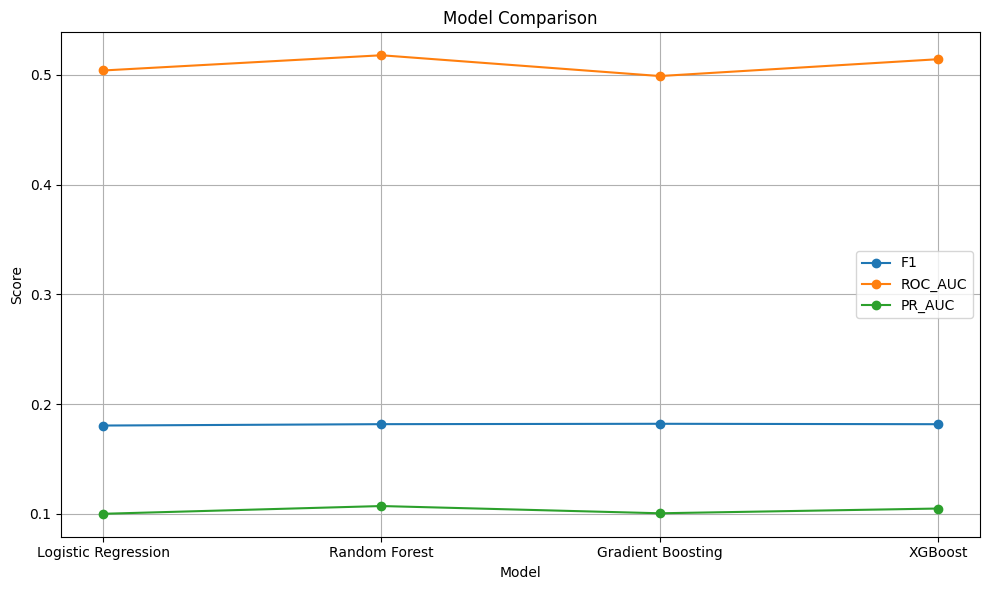

In [10]:
# Pick only the most useful metrics to avoid clutter
metrics_to_plot = ["F1", "ROC_AUC", "PR_AUC"]

plt.figure(figsize=(10,6))

for i, metric in enumerate(metrics_to_plot):
    plt.plot(results_df.index, results_df[metric], marker='o', label=metric)

plt.title("Model Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# Pick the best by PR-AUC 
best_by_prauc = results_df["PR_AUC"].idxmax()
print(f"\nBest model by PR-AUC: {best_by_prauc}")


Best model by PR-AUC: Random Forest


In [12]:
# Save the selected model
joblib.dump(rf, "random_forest.pkl", compress=3)

['random_forest.pkl']

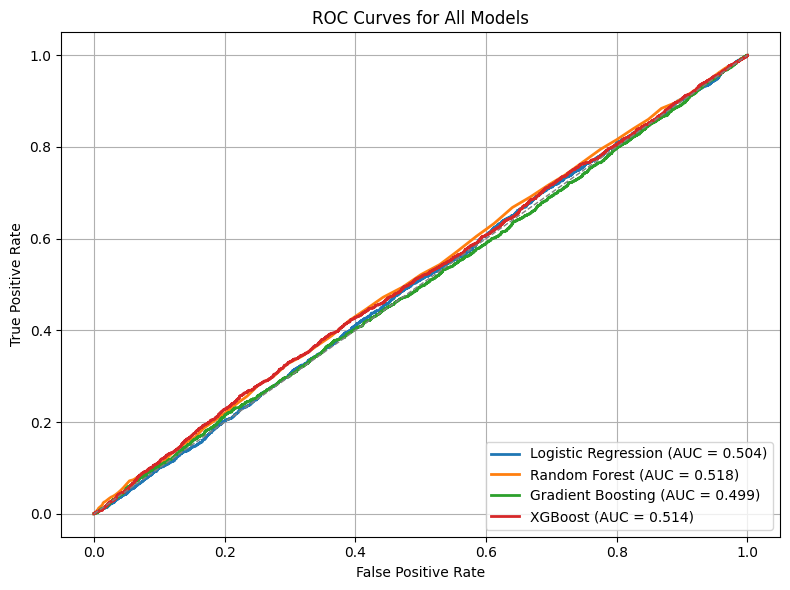

ROC curves saved as 'roc_curves_comparison.png'.


<Figure size 500x500 with 0 Axes>

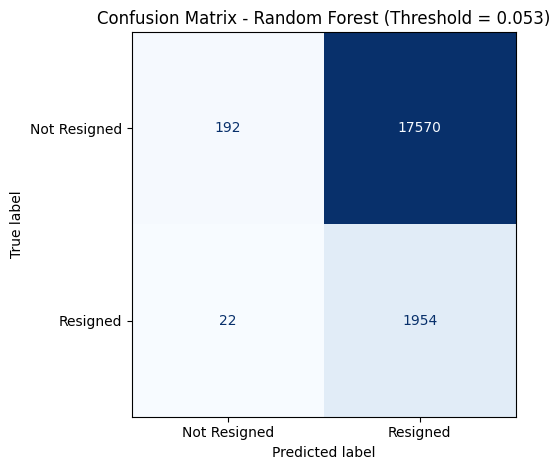

Confusion matrix saved as 'confusion_matrix_random_forest.png'.


In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# === ROC CURVES FOR ALL MODELS ===

models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "Gradient Boosting": gb,
    "XGBoost": xgb
}

plt.figure(figsize=(8, 6))

for name, model in models.items():
    # Get predicted probabilities for class 1
    y_proba = model.predict_proba(X_test_proc)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

# Plot settings
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curves_comparison.png", dpi=300)
plt.show()

print("ROC curves saved as 'roc_curves_comparison.png'.")


# === CONFUSION MATRIX FOR BEST MODEL (Random Forest) ===

# Use tuned threshold from your earlier evaluation
best_threshold = results_df.loc["Random Forest", "Threshold"]

# Predict probabilities and apply custom threshold
rf_test_proba = rf.predict_proba(X_test_proc)[:, 1]
rf_y_pred = (rf_test_proba >= best_threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, rf_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Resigned", "Resigned"])

# Plot confusion matrix
plt.figure(figsize=(5, 5))
disp.plot(cmap="Blues", values_format='d', colorbar=False)
plt.title(f"Confusion Matrix - Random Forest (Threshold = {best_threshold:.3f})")
plt.tight_layout()
plt.savefig("confusion_matrix_random_forest.png", dpi=300)
plt.show()

print("Confusion matrix saved as 'confusion_matrix_random_forest.png'.")
